# Diabetes prediction: gradient boosting

## Notebook set-up

In [5]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import GradientBoostingClassifier

import configuration as config
import functions as funcs

## 1. Data preparation

### 1.1. Load data from disk

In [6]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

training_df=dataset['training']
testing_df=dataset['testing']

### 1.2. Inspect

In [7]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
717,10,94.0,72.0,18.0,NaN,23.1,0.595,56,0
64,7,114.0,66.0,NaN,NaN,32.8,0.258,42,1
510,12,84.0,72.0,31.0,NaN,29.7,0.297,46,1
104,2,85.0,65.0,NaN,NaN,39.6,0.930,27,0
657,1,120.0,80.0,48.0,200.0,38.9,1.162,41,0


## 2. Baseline model

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

hgb = HistGradientBoostingClassifier(random_state=42)  # accepts NaNs
hgb.fit(X_train, y_train)
y_pred = hgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.75


In [20]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd

X = training_df.drop("Outcome", axis=1)
y = training_df["Outcome"]

# optional: see where NaNs are
print(X.isna().sum().sort_values(ascending=False).head())

pipe = make_pipeline(
    SimpleImputer(strategy="median"),          # fills NaNs
    GradientBoostingClassifier(random_state=42)
)

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

scores = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring={"accuracy": "accuracy", "f1": "f1"},
    n_jobs=-1,
    return_train_score=False
)

print(f"CV Accuracy: {np.mean(scores['test_accuracy']):.3f} ± {np.std(scores['test_accuracy']):.3f}")

Insulin          193
SkinThickness    122
BloodPressure     20
BMI                7
Glucose            3
dtype: int64
CV Accuracy: 0.761 ± 0.025


## 3. Hyperparameter optimization

### 3.1. Hyperparameter grid search

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X_train = training_df.drop("Outcome", axis=1)
y_train = training_df["Outcome"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),     # handles NaNs
    ("gb", GradientBoostingClassifier(random_state=42))
])


# compact grid so it finishes quickly
param_grid = {
    "gb__n_estimators":     [100, 200, 300],
    "gb__learning_rate":    [0.05, 0.1, 0.2],
    "gb__max_depth":        [2, 3, 4],
    "gb__subsample":        [0.6, 0.8, 1.0],
    "gb__max_features":     [None, "sqrt", "log2"],
    "gb__min_samples_leaf": [1, 3, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_results = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",          
    refit=True,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)

search_results.fit(X_train, y_train)
model = search_results.best_estimator_

print("Best params:", search_results.best_params_)
print("Best CV accuracy:", search_results.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best params: {'gb__learning_rate': 0.05, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__min_samples_leaf': 1, 'gb__n_estimators': 200, 'gb__subsample': 0.8}
Best CV accuracy: 0.7943950786056049


### 3.2. Hyperparameter optimization results

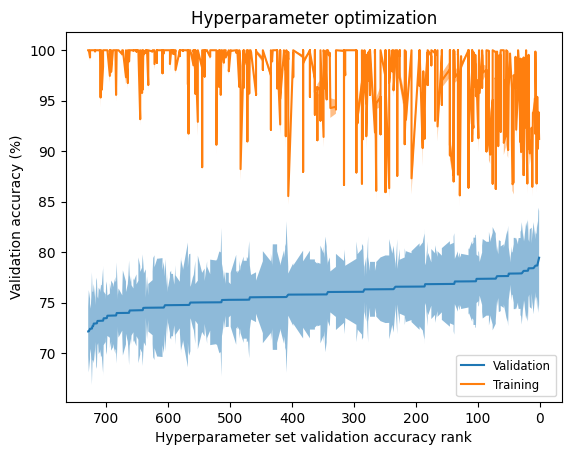

In [24]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

In [ ]:
optimized_model = search_results.best_estimator_

X = training_df.drop("Outcome", axis=1)
y = training_df["Outcome"]

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

cv_scores = cross_validate(
    optimized_model,
    X, y,
    cv=cv,
    scoring={"accuracy": "accuracy"},
    n_jobs=-1,
    return_train_score=False
)

# Summary
acc_mean, acc_std = np.mean(cv_scores["test_accuracy"]), np.std(cv_scores["test_accuracy"])

cv_table = pd.DataFrame({
    "Fold": range(1, len(cv_scores["test_accuracy"]) + 1),
    "Accuracy": cv_scores["test_accuracy"],
})

print(f"Optimized model — CV Accuracy: {acc_mean:.3f} ± {acc_std:.3f}")

Optimized model — CV Accuracy: 0.768 ± 0.035


## 4. Evaluation

### 4.1. Model comparison

In [41]:
# This time, compare the optimized version of all three models: decision tree, random forest and gradient boosting. You might also want to throw in a logistic regression as a standard of comparison.

models={}

models['Logistic regression']=LogisticRegression().fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree']=pickle.load(input_file)

with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest']=pickle.load(input_file)

models['Gradient boosting']=model

cross_val_scores={
    'Model': [],
    'Score': []
}

for model_name, model in models.items():

    scores=cross_val_score(
        model,
        training_df.drop('Outcome', axis=1),
        training_df['Outcome'],
        cv=30,
        n_jobs=-1
    )

    cross_val_scores['Model'].extend([model_name]*len(scores))
    cross_val_scores['Score'].extend(scores)

sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.show()
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.show()

NameError: name 'LogisticRegression' is not defined

### 4.2. Test set performance

In [ ]:
# Evaluate the test set performance of all three models
# Your code here...

## 5. Save

### 5.1. Optimized hyperparameters

In [ ]:
with open(config.GRADIENT_BOOSTING_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(hyperparameters.best_params_, output_file)

### 5.2. Model

In [ ]:
with open(config.GRADIENT_BOOSTING_MODEL, 'wb') as output_file:
    pickle.dump(model, output_file)